In [1]:
%%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [2]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.17: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.visual` require gradients


### Data Prep

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [4]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [5]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

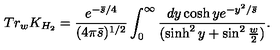

In [8]:
dataset[55]["image"]

In [9]:
dataset[55]["text"]

'T r _ { w } K _ { H _ { 2 } } = { \\frac { e ^ { - { \\bar { s } / 4 } } } { ( 4 \\pi \\bar { s } ) ^ { 1 / 2 } } } \\int _ { 0 } ^ { \\infty } { \\frac { d y \\cosh y e ^ { - { y ^ { 2 } / \\bar { s } } } } { ( \\sinh ^ { 2 } y + \\sin ^ { 2 } { \\frac { w } { 2 } } ) } } .'

In [10]:
from IPython.display import display, Math, Latex
latex = dataset[55]["text"]
display(Math(latex))

<IPython.core.display.Math object>

In [11]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [12]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [14]:
converted_dataset[55]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=280x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'T r _ { w } K _ { H _ { 2 } } = { \\frac { e ^ { - { \\bar { s } / 4 } } } { ( 4 \\pi \\bar { s } ) ^ { 1 / 2 } } } \\int _ { 0 } ^ { \\infty } { \\frac { d y \\cosh y e ^ { - { y ^ { 2 } / \\bar { s } } } } { ( \\sinh ^ { 2 } y + \\sin ^ { 2 } { \\frac { w } { 2 } } ) } } .'}]}]}

In [17]:
FastVisionModel.for_inference(model)

image = dataset[55]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.0, min_p = 0.1)

$$T r _ { w } K _: _::::

\begin{array} {:::
:::-mathrm {::-:::
:, text = {::
:
:
:-::
:
:,:::
:-::
:
:(""+100:::(""+:::-::楽しさ
::(""+::(""+::楽し�:::,::(""+::
:
:(""+::-::(""+::,::
:
<|im_start|>


### Train the model

In [21]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 50,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
        # vision fine-tune
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [22]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936/7,000,000,000 (0.73% trained)


Step,Training Loss
1,0.155400
2,0.063500
3,0.162000
4,0.115000
5,0.079800
6,0.076900
7,0.117600
8,0.118500
9,0.084300
10,0.099800


In [23]:
FastVisionModel.for_inference(model)
image = dataset[55]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.0, min_p = 0.1)

T r _ { w } K _ { H _ { 2 } } = \frac { e ^ { - \frac { w } { 8 } } / 1 } { ( 4 \pi \bar { s } ) ^ { 1 / 2 } } \int _ { 0 } ^ { \infty } \frac { d y \, c o s y e ^ { - y ^ { 2 } / 8 } } { ( \sin ^ { 2 } y + \sin ^ { 2 } \frac { y } { 2 } ) } .


### Saving, loading finetuned models

In [24]:
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")

[]